In [51]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip

# load pickle module
import pickle

In [2]:
parameter = scipy.io.loadmat('../data/parameterestimate.mat')

/Users/qingyao/anaconda3/envs/geo/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [44]:
fips = pd.read_csv('../data/testfips.csv')

In [49]:
fips.iloc[1858]

ID                     1859
Name     New York County NY
FIPS                  36061
STATE                    36
Name: 1858, dtype: object

In [6]:
beta = parameter['beta'] ## transmission rate

In [7]:
alpha = parameter['alpha'] ## reporting rate 

In [24]:
parameter['None']

MatlabOpaque([(b'Tstart', b'MCOS', b'datetime', array([[3707764736],
                     [         2],
                     [         1],
                     [         1],
                     [         2],
                     [         2]], dtype=uint32))                  ],
             dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')])

## Parameter estimates for COVID-19 in 2020

Data contains the daily estimates of transmission rate beta in each county and daily reporting rate alpha in each county. There is a list of FIPS numbers for the estimates. Note, for some counties with zero or low cases, the estimates may not be reliable (lack of information).

The first day of the estimates is Feb 21, 2020. Both beta and alpha are in the format: 3142 X 100 X 315. 3142 corresponds to 3124 counties; 100 corresponds to 100 ensemble members (you can use mean value); 315 means estimates in 315 days, starting from Feb 21.

In [55]:
beta_mean = np.mean(beta,axis=1)
alpha_mean = np.mean(alpha,axis=1)

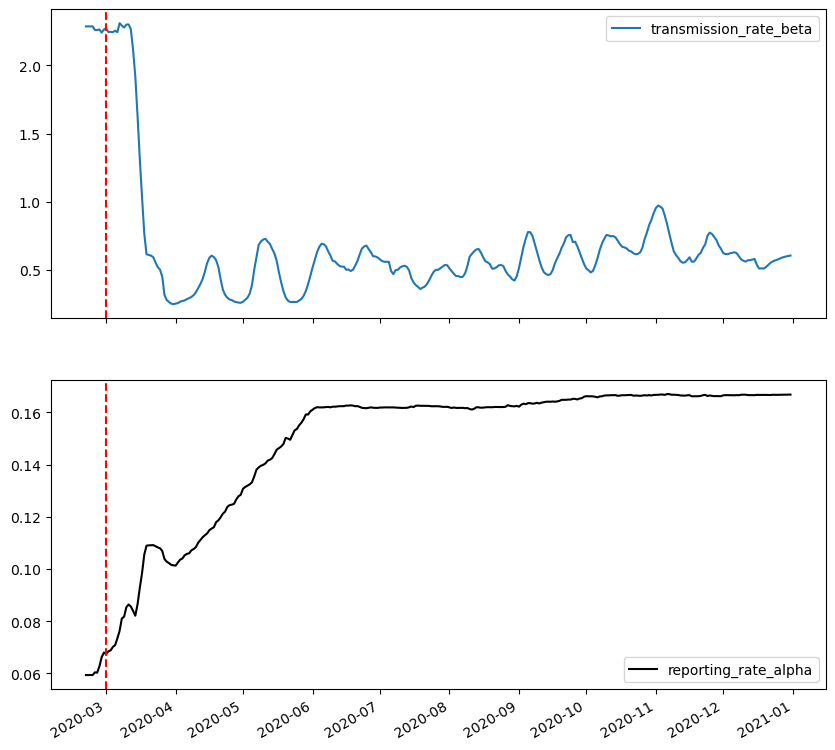

In [90]:
## visualise the beta of ny in 1858

import matplotlib.dates as mdates


# Generate dates from 2020-02-21 to 2020-12-31
dates = pd.date_range(start='2020-02-21', end='2020-12-31')

# Create some example data

# plt.figure(figsize=(10,5))
# plt.plot(dates, beta_mean[1858])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

# First subplot
ax1.plot(dates, beta_mean[1858],label='transmission_rate_beta')
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # set major ticks to first day of each month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # set format of the dates
ax1.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--')  # add vertical line
ax1.legend()

# Second subplot
ax2.plot(dates, alpha_mean[1858],c='black',label='reporting_rate_alpha')
ax2.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--')  # add vertical line
ax2.legend()


fig.autofmt_xdate()  # Rotate x-axis labels for better formatting if they overlap

plt.show()

# plt.plot(beta_mean[1858])


In [64]:
cases = pd.read_csv('/Users/qingyao/OneDrive - cumc.columbia.edu/machine_learning_data/county_data/ts_covid19_confirmed_US_mainland.csv')

In [67]:
cases[cases.FIPS == 36061]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,03/01/2023,03/02/2023,03/03/2023,03/04/2023,03/05/2023,03/06/2023,03/07/2023,03/08/2023,03/09/2023
1824,84036061,US,USA,840,36061,New York,New York,US,40.767273,-73.971526,...,595118,595203,595458,595628,595628,595628,596044,596132,596196,596334


In [78]:
cases.columns[41:41+315] ### the 315 days to be selected

Index(['2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20',
       '2/27/20', '2/28/20', '2/29/20', '03/01/2020',
       ...
       '12/22/20', '12/23/20', '12/24/20', '12/25/20', '12/26/20', '12/27/20',
       '12/28/20', '12/29/20', '12/30/20', '12/31/20'],
      dtype='object', length=315)

In [83]:
dates_col = cases.columns[41:41+315] 

In [81]:
ny_cases = cases[cases.FIPS == 36061]

In [114]:
ny_cases[cases.columns[41:55] ] ### march 5 is the first reported cases

,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,03/01/2020,03/02/2020,03/03/2020,03/04/2020,03/05/2020
1824,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [93]:
np.array(ny_cases[dates_col])[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     1,     2,     5,     5,     5,
          12,    24,    27,    45,    84,   112,   172,   241,   402,
         737,  1174,  1544,  2066,  2673,  3078,  3520,  4062,  4585,
        5216,  5806,  6228,  6876,  8173,  8997,  9625, 10212, 10878,
       11573, 11984, 12365, 13119, 13754, 14323, 14913, 15433, 15755,
       16032, 16440, 16900, 17348, 17719, 18057, 18259, 18454, 18847,
       19233, 19633, 20043, 20458, 20609, 20719, 21027, 21354, 21646,
       21866, 22114, 22257, 22363, 22587, 22833, 23000, 23120, 23225,
       23303, 23400, 23595, 23760, 23919, 24073, 24213, 24267, 24318,
       24451, 24618, 24784, 24929, 25082, 25131, 25202, 25273, 25401,
       25511, 25610, 25684, 25724, 25750, 25829, 25901, 25976, 26064,
       26117, 26152, 26179, 26260, 26327, 26397, 26456, 26517, 26542,
       26571, 26634, 26702, 26772, 26830, 26887, 26933, 26960, 27025,
       27106, 27179,

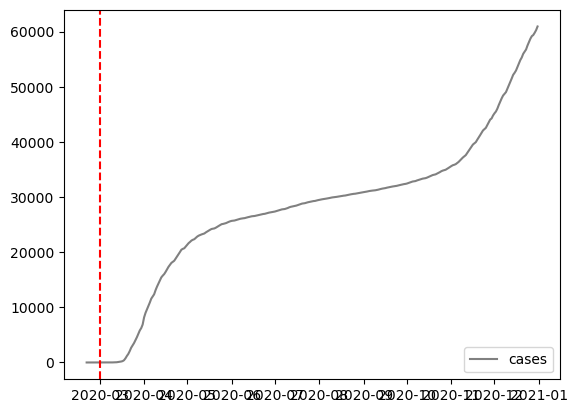

In [95]:
# third subplot
plt.plot(dates, ,c='gray',label='cases')
plt.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--')  # add vertical line
fig.autofmt_xdate()  # Rotate x-axis labels for better formatting if they overlap

plt.legend()

In [102]:
dates_col_cul = cases.columns[40:41+315] 

In [103]:
daily_cases_ny = np.diff(np.array(ny_cases[dates_col_cul])[0])

In [104]:
infections = daily_cases_ny / beta_mean[1858]

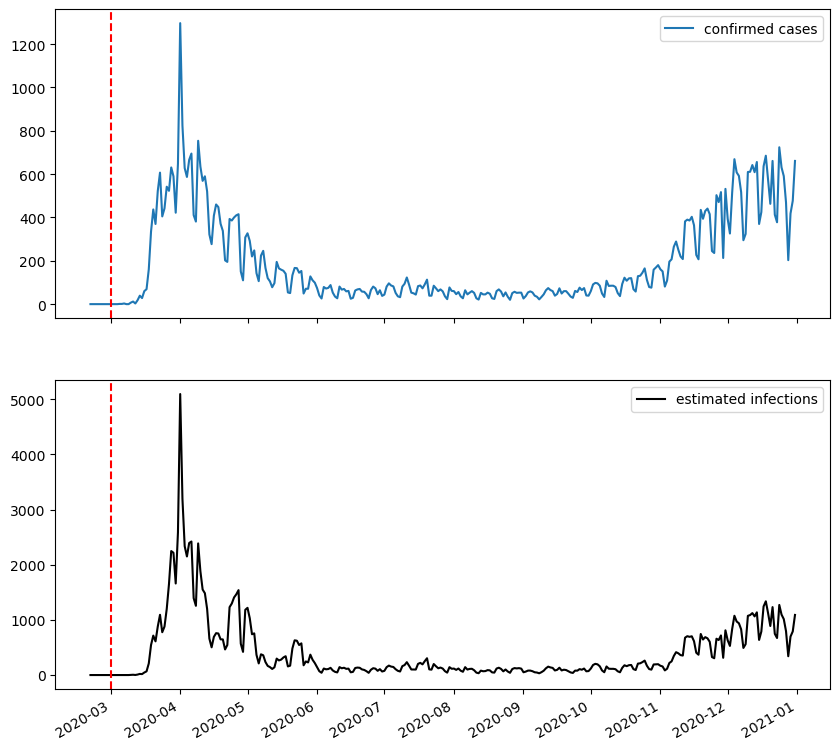

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

# First subplot
ax1.plot(dates, daily_cases_ny,label='confirmed cases')
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # set major ticks to first day of each month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # set format of the dates
ax1.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--')  # add vertical line
ax1.legend()

# Second subplot
ax2.plot(dates, infections,c='black',label='estimated infections')
ax2.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--')  # add vertical line
ax2.legend()


fig.autofmt_xdate()  # Rotate x-axis labels for better formatting if they overlap

plt.show()


In [109]:
data_series = pd.Series(daily_cases_ny)
moving_average = data_series.rolling(window=7).mean()

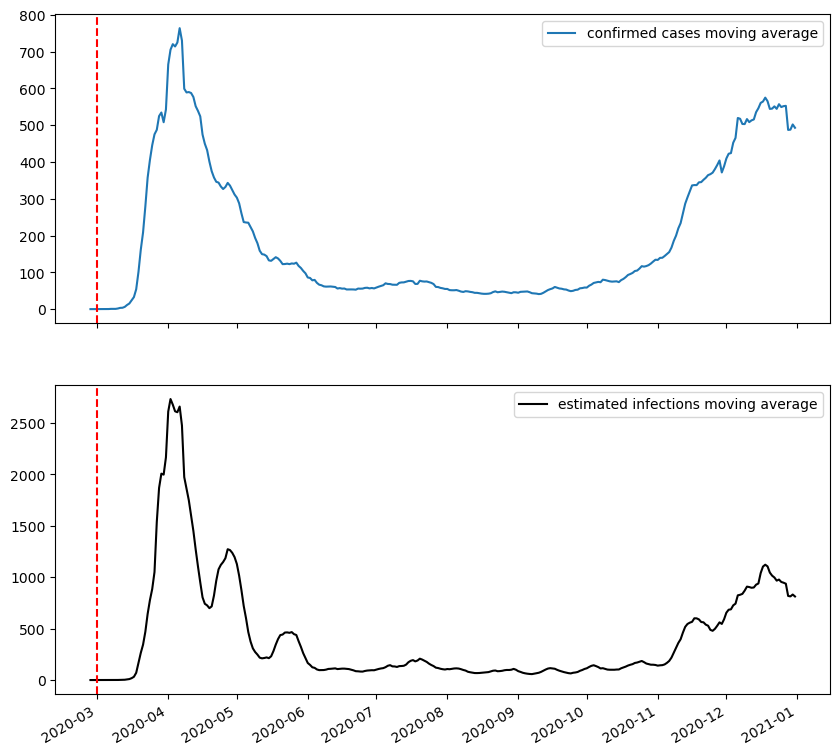

In [111]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

# First subplot
ax1.plot(dates, moving_average,label='confirmed cases moving average')
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # set major ticks to first day of each month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # set format of the dates
ax1.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--')  # add vertical line
ax1.legend()

# Second subplot
ax2.plot(dates, moving_average/beta_mean[1858],c='black',label='estimated infections moving average')
ax2.axvline(pd.Timestamp('2020-03-01'), color='r', linestyle='--')  # add vertical line
ax2.legend()


fig.autofmt_xdate()  # Rotate x-axis labels for better formatting if they overlap

plt.show()
